In [ ]:
# Imports
from src.data_retrieval import init_osm
from src.preprocessing import load_roads, load_railways, load_water_polygons, get_local_crs, reproject_all, build_water_edges, prepare_water_geometries
from src.prepare_pois import load_pois_with_green, prepare_pois, assign_pois_to_blocks
from src.process_blocks import construct_blocks, filter_water_blocks, filter_small_blocks, filter_irregular_blocks, remove_false_water_blocks
from src.plotting import plot_block_graph, plot_blocks_with_pois, plot_ge_heatmap, plot_variance, plot_largest_component, plot_variance_distribution_from_results
from src.construct_graph import build_block_graph
from src.network_analysis import get_largest_component, prepare_category_dicts, compute_generalized_euclidean_matrix, load_Q, compute_and_store_Q, compute_variance, compute_z_scores, shuffled_variances, compute_livability_from_matrix
from src.network_distance import ge, _ge_Q, variance, _resistance, calculate_spl


In [26]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

Setup

In [27]:
# CITY_NAME = "Copenhagen"
CITY_NAME = "Gdansk"

# Initialize OSM
osm, boundary = init_osm(CITY_NAME)

Downloaded Protobuf data 'Gdansk.osm.pbf' (36.89 MB) to:
'/home/zuziaderylo/masters_thesis/data/raw/Gdansk.osm.pbf'


In [28]:
roads = load_roads(osm)
railways = load_railways(osm)
water_polygons = load_water_polygons(osm)
pois = load_pois_with_green(osm)

/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


Loaded 33140 regular POIs
Loaded 251 green-space features
Total combined POIs: 33391


In [29]:
# Compute city-local UTM projection
local_epsg = get_local_crs(boundary)
print(f"Using local CRS: EPSG:{local_epsg}")

# Reproject all at once
layers = {
    "boundary": boundary,
    "roads": roads,
    "railways": railways,
    "water_polygons": water_polygons,
    "pois": pois
}
layers = reproject_all(layers, local_epsg)

# Unpack
boundary = layers["boundary"]
roads = layers["roads"]
railways = layers["railways"]
water_polygons = layers["water_polygons"]
pois = layers["pois"]

Using local CRS: EPSG:32634


In [30]:
print(boundary.crs)

EPSG:32634


In [31]:
# Build water edges after reprojection
water_edges = build_water_edges(layers["water_polygons"])

# Change water geometries
water_polygons = prepare_water_geometries(water_polygons)

In [32]:
# Prepare pois
pois = prepare_pois(pois=pois)

Number of POIs after cleaning: 33368
Assigned categories for 19019 POIs (57.0% coverage)
Number of POIs after categorization: 33368


In [33]:
len(roads)

138385

In [34]:
len(water_edges)

1843

In [35]:
len(railways)

14541

In [36]:
# Create initial blocks
initial_blocks = construct_blocks(roads, railways, water_edges)

len(initial_blocks)

10127

In [37]:
# Process blocks
blocks_no_water = filter_water_blocks(initial_blocks, water_polygons)

In [38]:
# Use blocks_no_water (before small-block merging)
blocks = blocks_no_water.copy()

# Compute area (in square meters)
blocks["area_m2"] = blocks.geometry.area

# Calculate percentiles
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(blocks["area_m2"], percentiles)

# Print the percentile values and how many blocks fall below each
for perc, value in zip(percentiles, percentile_values):
    count = (blocks["area_m2"] <= value).sum()
    print(f"{perc}th percentile: {value:.2f} m² → {count} blocks")

5th percentile: 73.99 m² → 436 blocks
10th percentile: 166.50 m² → 871 blocks
25th percentile: 559.05 m² → 2176 blocks
50th percentile: 1970.20 m² → 4352 blocks
75th percentile: 8553.69 m² → 6527 blocks
90th percentile: 26959.66 m² → 7832 blocks
95th percentile: 53840.79 m² → 8267 blocks


In [39]:
# Prepare safe copies of the data
area_values = blocks["area_m2"].copy()
log_area_values = np.log10(area_values)

# Percentiles to plot
percentiles = [10, 25, 50, 75, 90]

# Calculate percentiles for both versions
linear_percentile_values = np.percentile(area_values, percentiles)
log_percentile_values = np.percentile(log_area_values, percentiles)

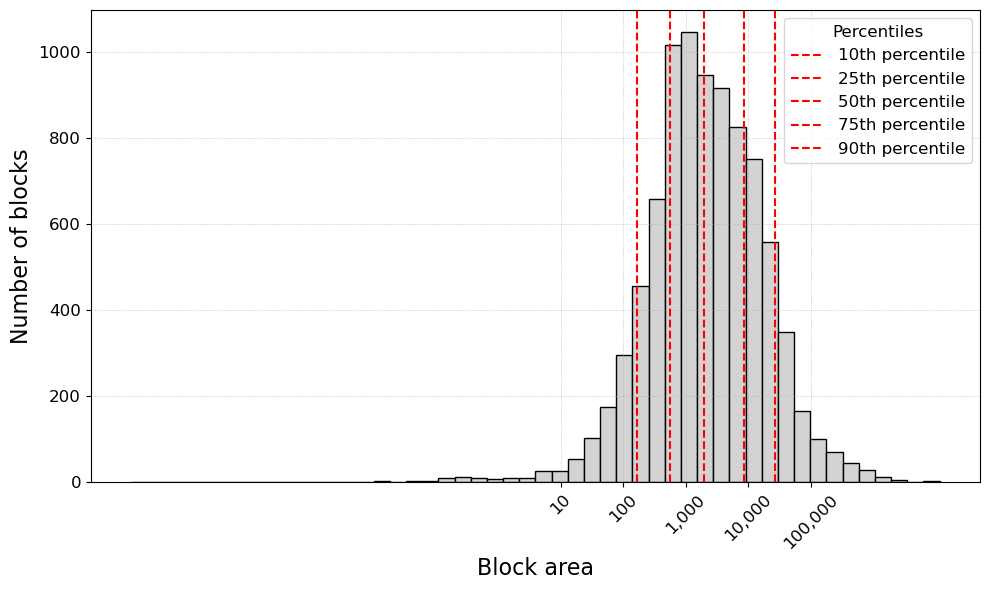

In [40]:
# Log-transform area
blocks["log_area"] = np.log10(blocks["area_m2"])

# Calculate percentiles in log space
percentiles = [10, 25, 50, 75, 90]
percentile_values = np.percentile(blocks["log_area"], percentiles)

# Plot histogram of log-transformed area
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    blocks["log_area"], 
    bins=50, 
    color="lightgray", 
    edgecolor="black"
)

# Add vertical lines at percentiles
for perc, value in zip(percentiles, percentile_values):
    ax.axvline(
        x=value,
        color="red",
        linestyle="--",
        linewidth=1.5,
        label=f"{perc}th percentile"
    )

# Set log-space ticks but label with real m² values
log_tick_vals = np.arange(1, 6)
area_tick_labels = [f"{int(10**v):,}" for v in log_tick_vals]

ax.set_xticks(log_tick_vals)
ax.set_xticklabels(area_tick_labels, rotation=45, fontsize=14)

# Axis labels
ax.set_xlabel("Block area", fontsize=16)
ax.set_ylabel("Number of blocks", fontsize=16)

# Optional title
# ax.set_title(
#     "Block Area Distribution with Percentile Thresholds",
#     fontsize=15
# )

# Grid
ax.grid(True, which="both", linestyle=":", linewidth=0.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
    fontsize=12,
    title="Percentiles",
    title_fontsize=12
)

# Tick label sizes (y-axis)
ax.tick_params(axis="both", which="major", labelsize=12)

# Save figure and show
plt.tight_layout()
plt.savefig(
    "gdansk_block_area_distribution.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


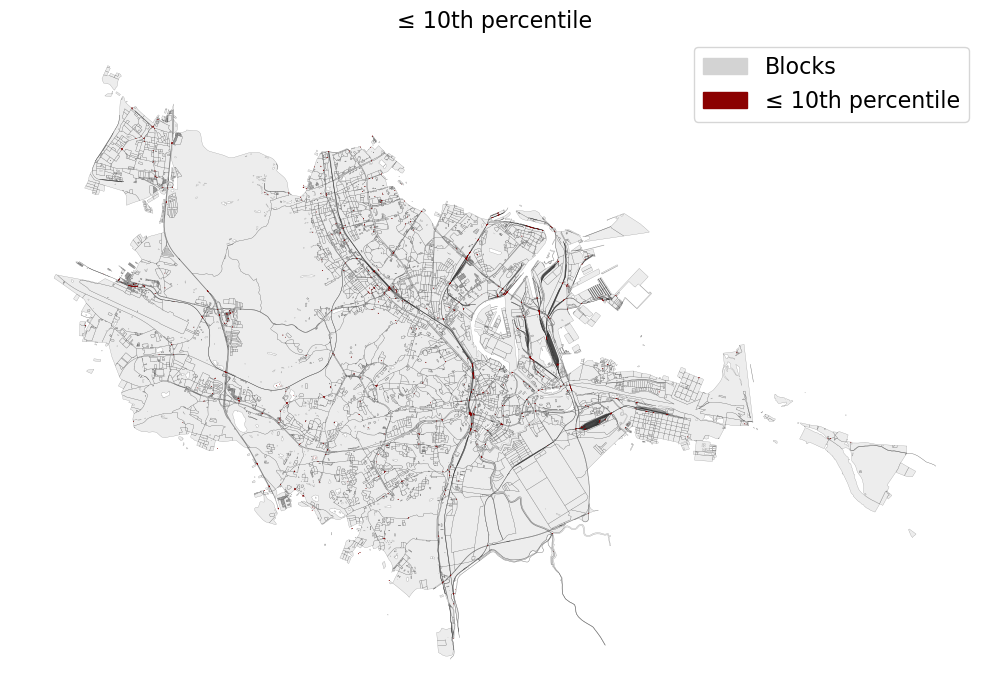

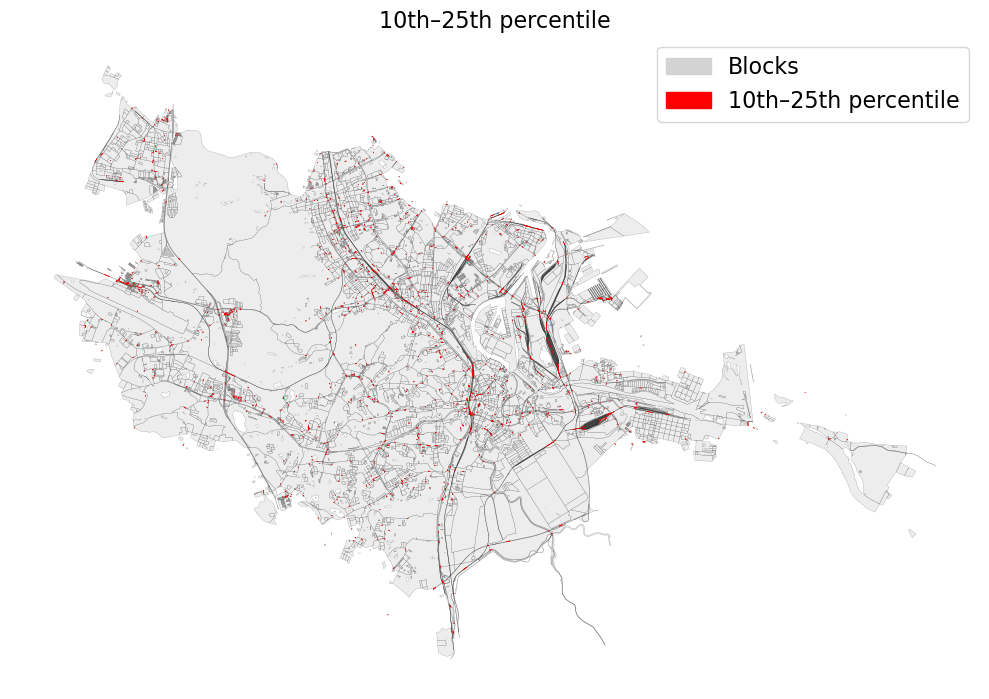

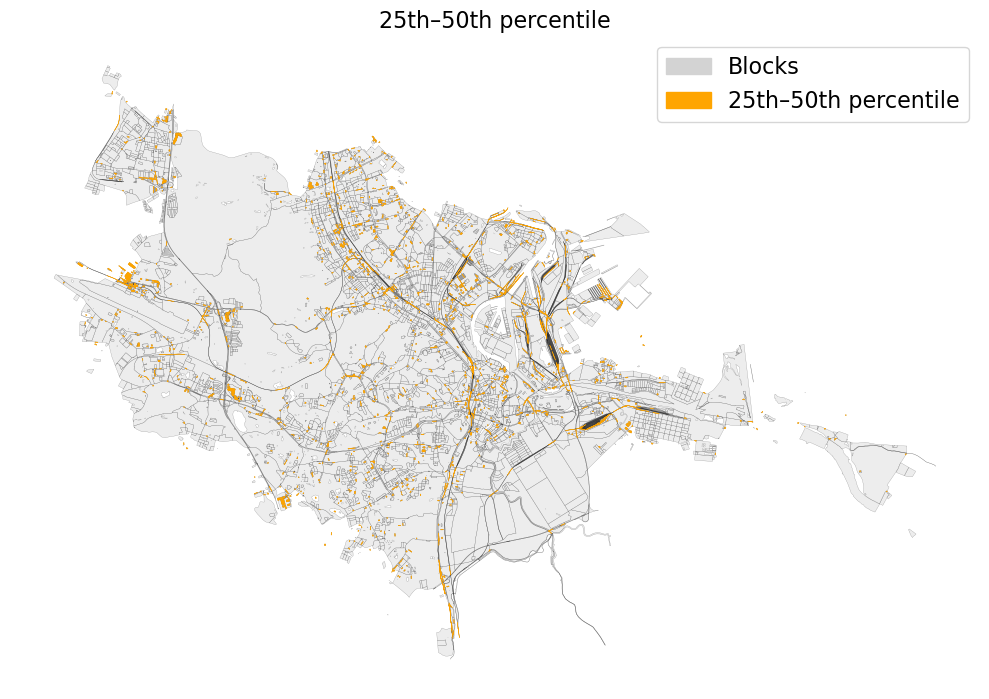

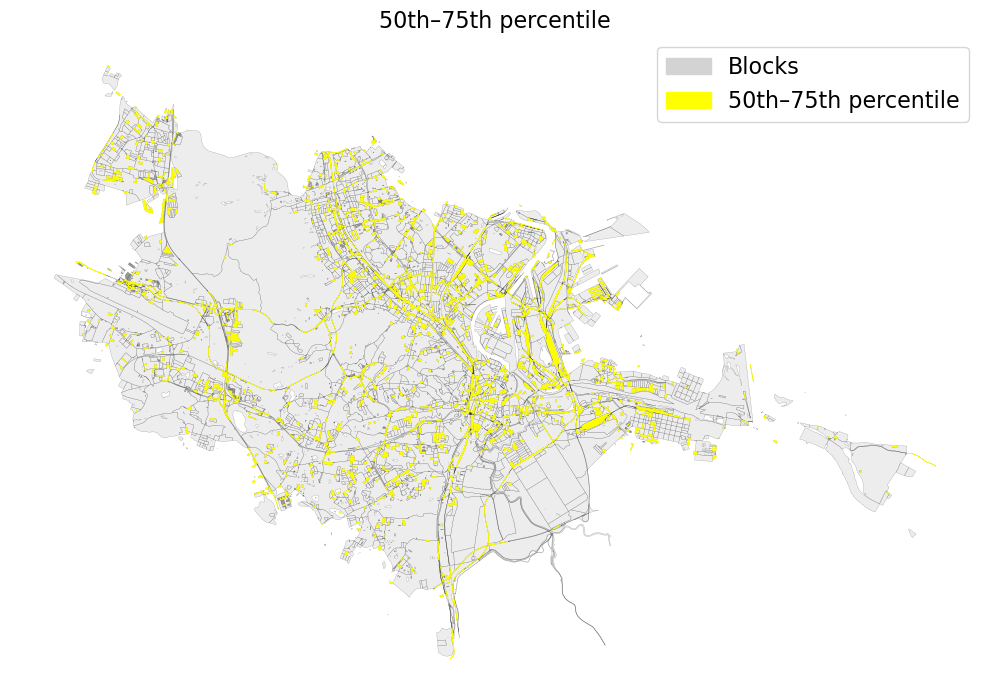

In [41]:
import matplotlib.patches as mpatches

# Compute area percentiles
areas = blocks.geometry.area
p10 = np.percentile(areas, 10)
p25 = np.percentile(areas, 25)
p50 = np.percentile(areas, 50)
p75 = np.percentile(areas, 75)

# Subsets
groups = {
    "≤ 10th percentile": blocks[areas <= p10],
    "10th–25th percentile": blocks[(areas > p10) & (areas <= p25)],
    "25th–50th percentile": blocks[(areas > p25) & (areas <= p50)],
    "50th–75th percentile": blocks[(areas > p50) & (areas <= p75)],
}

colors = {
    "≤ 10th percentile": "darkred",
    "10th–25th percentile": "red",
    "25th–50th percentile": "orange",
    "50th–75th percentile": "yellow",
}

# Loop over groups and save each plot separately
for title, subset in groups.items():

    fig, ax = plt.subplots(figsize=(10, 10))

    # Background (all blocks)
    blocks.plot(
        ax=ax,
        color="lightgrey",
        edgecolor="black",
        linewidth=0.2,
        alpha=0.4
    )

    # Highlighted subset
    subset.plot(
        ax=ax,
        color=colors[title],
        edgecolor=colors[title],
        linewidth=0.3,
        alpha=1
    )

    # ---- Legend (explicit, consistent style) ----
    legend_handles = [
        mpatches.Patch(
            color="lightgrey",
            label="Blocks"
        ),
        mpatches.Patch(
            color=colors[title],
            label=title
        ),
    ]

    ax.legend(
        handles=legend_handles,
        loc="upper right",
        frameon=True,
        fontsize=16
    )

    # Formatting
    ax.set_title(title, fontsize=16)
    ax.axis("off")

    plt.tight_layout()

    # Create safe filename
    filename = (
        "gdansk_x_blocks_"
        + title.replace("≤", "le")
               .replace("–", "_")
               .replace(" ", "")
               .replace("th", "")
        + ".pdf"
    )

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


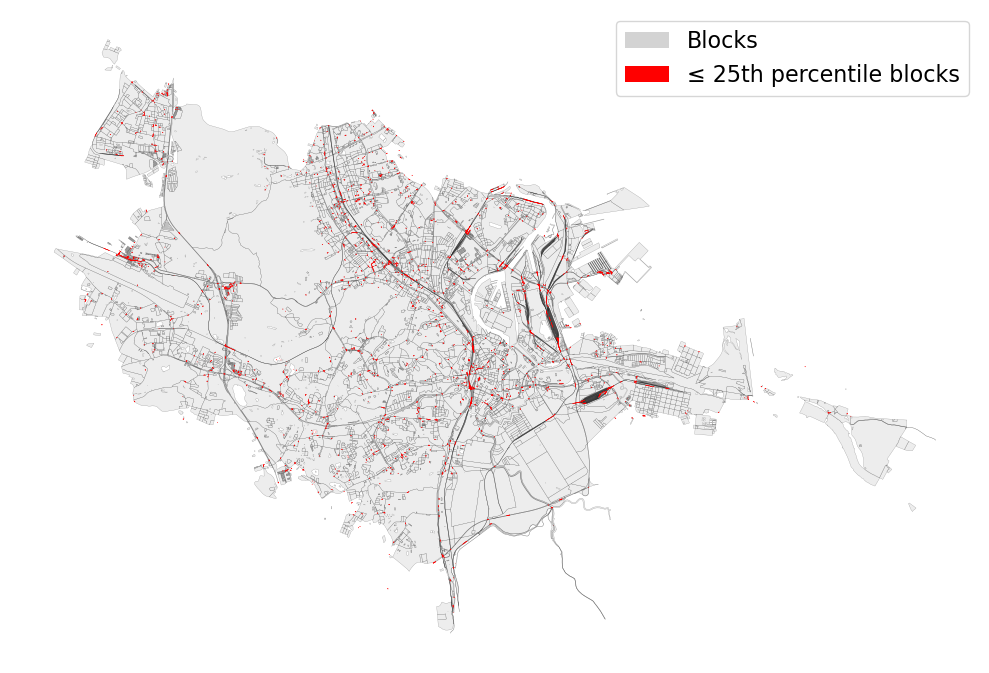

In [42]:
import matplotlib.patches as mpatches

# Compute area percentile
areas = blocks.geometry.area
p25 = np.percentile(areas, 25)

# Subset: ≤ 25th percentile
subset_25 = blocks[areas <= p25]
remaining = blocks.drop(subset_25.index, errors="ignore")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Background blocks
remaining.plot(
    ax=ax,
    facecolor="lightgray",
    edgecolor="black",
    linewidth=0.2,
    alpha=0.4
)

# Highlighted blocks (≤ 25th percentile)
subset_25.plot(
    ax=ax,
    facecolor="red",
    edgecolor="red",
    linewidth=0.3,
    alpha=1
)

# ---- Legend (explicit, like your example) ----
legend_handles = [
    mpatches.Patch(
        facecolor="lightgray",
        label="Blocks"
    ),
    mpatches.Patch(
        facecolor="red",
        label="≤ 25th percentile blocks"
    ),
]

ax.legend(
    handles=legend_handles,
    loc="upper right",
    frameon=True,
    fontsize=16
)

# Formatting
# ax.set_title("Blocks ≤ 25th percentile by area", fontsize=18)
ax.axis("off")
plt.tight_layout()

# Save
plt.savefig(
    "gdansk_blocks_25th_percentile.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [43]:
blocks_no_small = filter_small_blocks(blocks_no_water)
blocks_cleaned, suspicious = remove_false_water_blocks(blocks_no_small, area_quantile=0.999, compactness_quantile=0.03)


Iteration 1:
Threshold = 559.05 m²
Small blocks found = 2176
 Merged 2176 small blocks.
 Remaining blocks = 6527

Iteration 2:
Threshold = 559.05 m²
Small blocks found = 0
No small blocks left
Removed 1 suspected false-water blocks (area>100%, compactness<3%).


In [44]:
# Calculate compactness for each polygon and as a column
compactness_blocks = blocks_cleaned.copy()

# Perimeter is length
compactness_blocks["perimeter"] = compactness_blocks.geometry.length

# Compactness: Polsby-Popper (4π * Area / Perimeter²)
compactness_blocks["compactness"] = 4 * np.pi * compactness_blocks["area_m2"] / compactness_blocks["perimeter"]**2

# Closer to 1 means more compact

In [45]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # --- Select example blocks ---
# example_percentiles = [0.05, 0.5, 0.9]
# example_blocks = []

# for p in example_percentiles:
#     target = compactness_blocks["compactness"].quantile(p)
#     closest_idx = (compactness_blocks["compactness"] - target).abs().idxmin()
#     example_blocks.append(compactness_blocks.loc[[closest_idx]])

# example_blocks_gdf = pd.concat(example_blocks, ignore_index=True)

# # Labels (cleaner)
# panel_letters = ["(a)", "(b)", "(c)"]
# example_blocks_gdf["label"] = [
#     f"{panel_letters[i]} {int(p*100)}th percentile\nCompactness = {row['compactness']:.2f}"
#     for i, (p, (_, row)) in enumerate(zip(example_percentiles, example_blocks_gdf.iterrows()))
# ]

# # --- Plot: 1 row × 3 columns ---
# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# plt.subplots_adjust(wspace=0.02)

# for ax, (_, row) in zip(axs, example_blocks_gdf.iterrows()):
#     gdf_one = example_blocks_gdf.loc[[row.name]]

#     # Plot polygon
#     gdf_one.plot(
#         ax=ax,
#         color="0.85",          # light gray (prints well)
#         edgecolor="0.2",       # dark gray outline
#         linewidth=1.1
#     )

#     # Make each subplot nicely framed around its polygon
#     minx, miny, maxx, maxy = gdf_one.total_bounds
#     pad_x = (maxx - minx) * 0.25 if (maxx - minx) > 0 else 1
#     pad_y = (maxy - miny) * 0.25 if (maxy - miny) > 0 else 1
#     ax.set_xlim(minx - pad_x, maxx + pad_x)
#     ax.set_ylim(miny - pad_y, maxy + pad_y)

#     ax.set_aspect("equal")
#     ax.set_title(row["label"], fontsize=14)
#     ax.axis("off")

# # Optional: one overall caption-like title (often nice for thesis)
# # fig.suptitle("Example blocks at three compactness levels (Polsby–Popper)", fontsize=12)

# plt.savefig("block_examples_compactness.pdf", dpi=300, bbox_inches="tight")
# plt.show()


In [46]:
# Define percentiles and values
percentiles = [0.05, 0.10, 0.25, 0.5, 0.75, 0.9]
percentile_values = [compactness_blocks["compactness"].quantile(p) for p in percentiles]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
ax.hist(
    compactness_blocks["compactness"],
    bins=50,
    color="lightgray",
    edgecolor="black"
)

# Vertical lines for selected percentiles
for p, val in zip(percentiles, percentile_values):
    if p in [0.05, 0.10, 0.25, 0.5, 0.75, 0.9]:  # Label only key percentiles
        ax.axvline(x=val, color="red", linestyle="--", linewidth=1.5, label=f"{int(p*100)}th percentile")
    else:
        ax.axvline(x=val, color="red", linestyle="--", linewidth=1.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
    fontsize=12,
    title="Percentiles",
    title_fontsize=12
)

ax.tick_params(axis="both", which="major", labelsize=12)

# Title and formatting
# ax.set_title("Block Compactness Distribution with Percentile Thresholds", fontsize=13)
ax.set_xlabel("Compactness (Polsby–Popper score)", fontsize=16)
ax.set_ylabel("Number of blocks", fontsize=16)
ax.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()

# Save and close
plt.savefig("gdansk_compactness_histogram.pdf", dpi=300, bbox_inches="tight")
plt.close()

plt.show()


In [47]:
# Identify outliers (lowest 5%)
threshold = compactness_blocks["compactness"].quantile(0.05)
compact_blocks = compactness_blocks[compactness_blocks["compactness"] > threshold].copy()
irregular_blocks = compactness_blocks[compactness_blocks["compactness"] <= threshold].copy()

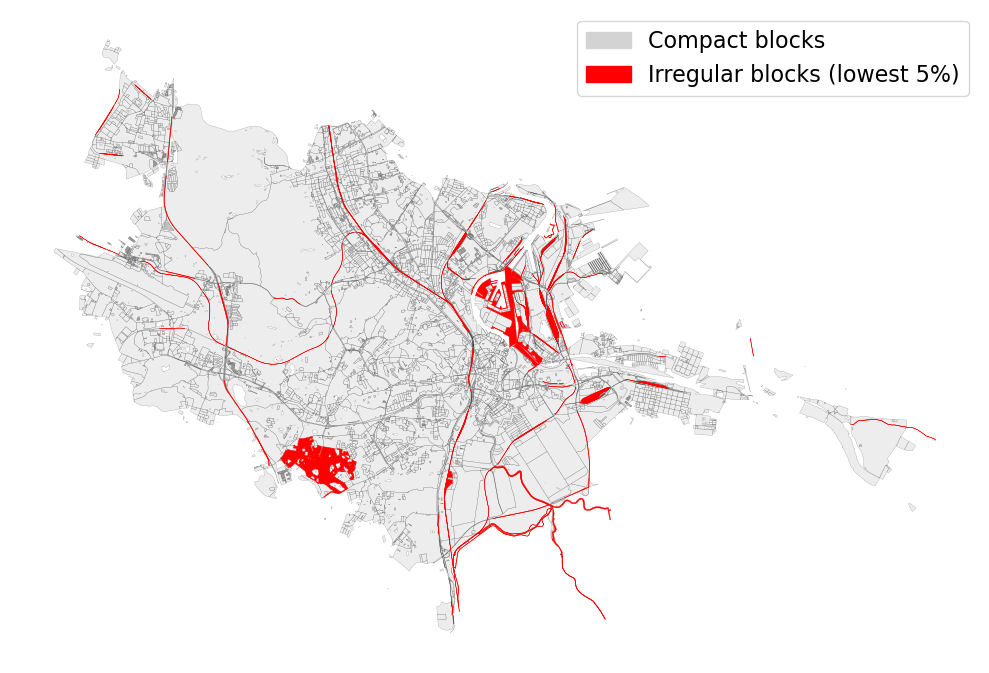

In [48]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot compact blocks 
compact_blocks.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.2, alpha=0.4)

# Plot irregular blocks 
irregular_blocks.plot(ax=ax, color="red", edgecolor="red", linewidth=0.3, alpha=1)

# Legend
legend_handles = [
    mpatches.Patch(color="lightgrey", label="Compact blocks"),
    mpatches.Patch(color="red", label="Irregular blocks (lowest 5%)")
]
ax.legend(handles=legend_handles, loc="upper right", frameon=True, fontsize=16)

# Title and formatting
# ax.set_title("Classification of Blocks by Compactness", fontsize=14)
ax.axis("off")
plt.tight_layout()

# # Save and close
plt.savefig("gdansk_compactness_blocks.pdf", dpi=300, bbox_inches="tight")
# plt.close()

plt.show()


In [13]:
# Process blocks
blocks_no_water = filter_water_blocks(initial_blocks, water_polygons)
blocks_no_small = filter_small_blocks(blocks_no_water)
blocks_cleaned, suspicious = remove_false_water_blocks(blocks_no_small, area_quantile=0.999, compactness_quantile=0.03)
blocks_no_irregular = filter_irregular_blocks(blocks_cleaned)

blocks = blocks_no_irregular

print(len(blocks))


Iteration 1:
Threshold = 558.17 m²
Small blocks found = 2177
 Merged 2177 small blocks.
 Remaining blocks = 6532

Iteration 2:
Threshold = 558.17 m²
Small blocks found = 0
No small blocks left
Removed 1 suspected false-water blocks (area>100%, compactness<3%).


/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be s

6008


/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
blocks_with_pois = assign_pois_to_blocks(pois, blocks)

blocks = blocks_with_pois

POIs assigned to 2279 blocks (out of 6008)


In [15]:
plot_blocks_with_pois(blocks=blocks_with_pois, city_name=CITY_NAME, title="block-level POI density", save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

In [16]:
blocks["area"] = blocks.geometry.area
blocks[["area"]].to_csv("block_sizes_gdansk.csv", index=False)

In [17]:
avg_block_area = blocks["area"].mean()
print("Average block area:", round(avg_block_area, 2))

Average block area: 30688.07


In [18]:
block_area_var = blocks["area"].var()
print("Block area variance:", round(block_area_var, 2))

Block area variance: 52649387945.99


In [19]:
q25 = blocks["area"].quantile(0.25)
q75 = blocks["area"].quantile(0.75)

area_total = blocks["area"].sum()
area_small = blocks.loc[blocks["area"] <= q25, "area"].sum() / area_total
area_large = blocks.loc[blocks["area"] >= q75, "area"].sum() / area_total

print(f"Area share of small blocks (<25th): {area_small:.2%}")
print(f"Area share of large blocks (>75th): {area_large:.2%}")

Area share of small blocks (<25th): 0.83%
Area share of large blocks (>75th): 90.36%


In [20]:
blocks["perimeter"] = blocks.geometry.length
blocks["compactness"] = (4 * np.pi * blocks["area"]) / (blocks["perimeter"] ** 2)
avg_compactness = blocks["compactness"].mean()
print("Average compactness:", round(avg_compactness, 3))

Average compactness: 0.486


In [21]:
n_pois = len(pois)
pois_per_block = n_pois / len(blocks)
print(f"Number of POIs: {n_pois}")
print(f"POIs per block: {pois_per_block:.2f}")

Number of POIs: 33241
POIs per block: 5.53


Graph

In [22]:
# Build graph from blocks with POIs
G = build_block_graph(blocks_with_pois)

Graph constructed: 6008 nodes, 16538 edges


In [23]:
plot_block_graph(G, blocks, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

In [24]:
# Select largest connected component
G_largest = get_largest_component(G)

Graph has 92 components.
Largest component: 5803 nodes, 16369 edges.


In [25]:
avg_degree = sum(dict(G_largest.degree()).values()) / G_largest.number_of_nodes()
print("Average degree:", round(avg_degree, 3))

Average degree: 5.642


In [26]:
density = nx.density(G_largest)
print("Density:", round(density, 5))

Density: 0.00097


Checking number of components and why they are not connected

In [27]:
plot_largest_component(blocks, G, CITY_NAME, title="largest connected component", save_path="report/figures")

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [28]:
# Compute Q
Q = compute_and_store_Q(G_largest, CITY_NAME)

In [29]:
# Load 
G_largest, Q = load_Q(CITY_NAME)

Graph nodes: 5803, Q shape: (5803, 5803)


In [30]:
# Prepare category dictionaries
category_counts = blocks_with_pois.attrs["category_counts"]
category_dicts_largest = prepare_category_dicts(category_counts, G_largest)

In [31]:
# Compute GE matrix
df_ge = compute_generalized_euclidean_matrix(G_largest, category_dicts_largest, ge=ge, Q_func=lambda G: Q)

df_ge.to_csv("data/processed/Copenhagen_results_GE.csv", index=False)


In [32]:
df_ge.shape

(9, 9)

In [33]:
df_ge.values.mean()

0.0712827756878121

In [34]:
print(len(pois))

33241


In [35]:
# Plot heatmap
plot_ge_heatmap(df_ge, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Gdansk Generalized Euclidean Distance between Amenity Categories'}>)

In [36]:
# Precompute resistance once
def precompute_resistance(G_largest):
    resistance_matrix = _resistance(G_largest)

    return resistance_matrix

In [37]:
resistance_matrix = precompute_resistance(G_largest)

In [38]:
# Compute variance for each category (using precomputed resistance matrix)
variance_categories = compute_variance(category_dicts_largest, G_largest, resistance_matrix)

                          variance
infrastructure_transport  0.551850
culture_leisure           0.262683
retail                    0.329183
other_daily_utilities     0.392009
green_spaces              0.330211
healthcare                0.348684
public_services           0.415796
education                 0.336063
food                      0.298408


In [39]:
plot_variance(variance_categories, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Gdansk Variance per Amenity Category'}, ylabel='Variance'>)

In [42]:
df_z = compute_z_scores(category_dicts_largest, G_largest, resistance_matrix, n_iter=1000)

In [43]:
# Store after computing df_z
SAVE_DIR = "data/processed"
df_z.to_csv(f"{SAVE_DIR}/{CITY_NAME}_results_z_scores.csv", index=True)

In [44]:
order = [
    "food",
    "retail",
    "education",
    "healthcare",
    "infrastructure_transport",
    "culture_leisure",
    "green_spaces",
    "public_services",
    "other_daily_utilities",
]

pretty_labels = [
    "Food",
    "Retail",
    "Education",
    "Healthcare",
    "Infrastructure & transport",
    "Culture & leisure",
    "Green spaces",
    "Public services",
    "Other daily utilities",
]

label_map = dict(zip(order, pretty_labels))


In [45]:
import os
import seaborn as sns

def plot_variance_distribution_from_results(category, df_z, label_map, CITY_NAME):

    # --- Create save directory ---
    save_root = "report/figures"
    save_dir = os.path.join(save_root, "zscores")
    os.makedirs(save_dir, exist_ok=True)

    rand_vars = df_z.loc[category, "rand_vars"]
    real_var  = df_z.loc[category, "real_var"]
    mean_rand = df_z.loc[category, "mean_rand"]
    std_rand  = df_z.loc[category, "std_rand"]
    z         = df_z.loc[category, "z_score"]

    pretty = label_map.get(category, category)

    # KDE peak calc
    plt.figure(figsize=(8, 5))
    tmp = sns.kdeplot(rand_vars, bw_adjust=1, color="black")
    x_vals = tmp.get_lines()[0].get_xdata()
    y_vals = tmp.get_lines()[0].get_ydata()
    plt.clf()

    plt.figure(figsize=(10, 5))

    sns.histplot(rand_vars, bins=30, stat='density',
                 color="lightgray", edgecolor=None, alpha=0.6)

    sns.kdeplot(rand_vars, bw_adjust=1, color="dimgray",
                linewidth=2, alpha=0.6, label="Distribution")

    plt.axvline(real_var, color="red", linestyle="--", linewidth=2,
                label=f"Observed variance = {real_var:.2f}")

    plt.axvline(mean_rand - std_rand, color="gray", linestyle="--", linewidth=1)
    plt.axvline(mean_rand + std_rand, color="gray", linestyle="--", linewidth=1)

    plt.xlabel("Variance")
    plt.ylabel("Density")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, color="lightgray", alpha=0.3)

    # ---- Title with city name ----
    plt.title(f"{CITY_NAME} - {pretty}: z-score = {z:.2f}", fontsize = 16)

    plt.legend()
    plt.tight_layout()

    # ---- SAVE FIGURE ----
    filename = f"{CITY_NAME}_{category}.pdf"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")

    plt.show()


<Figure size 800x500 with 0 Axes>

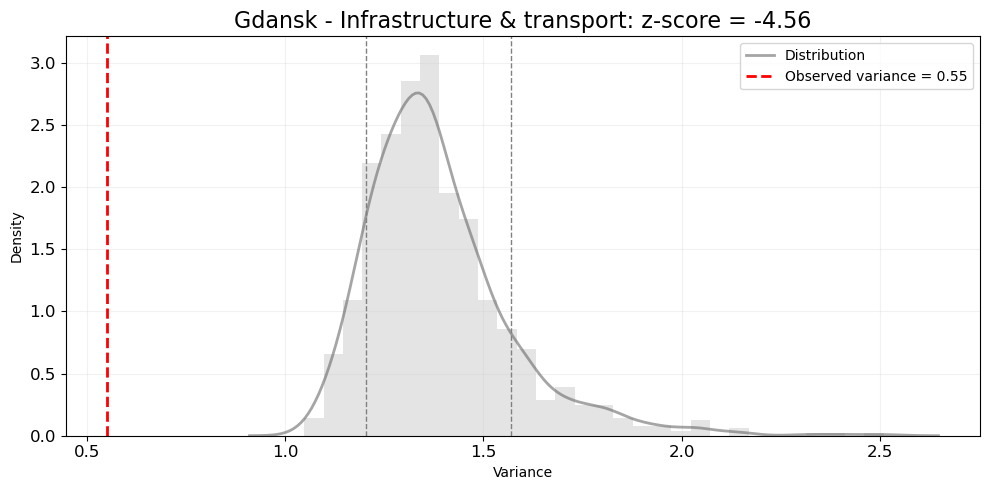

<Figure size 800x500 with 0 Axes>

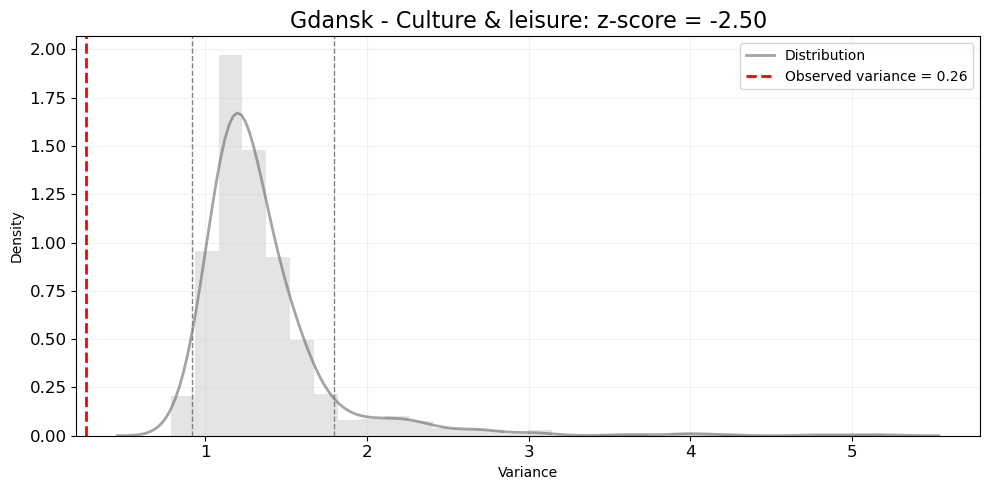

<Figure size 800x500 with 0 Axes>

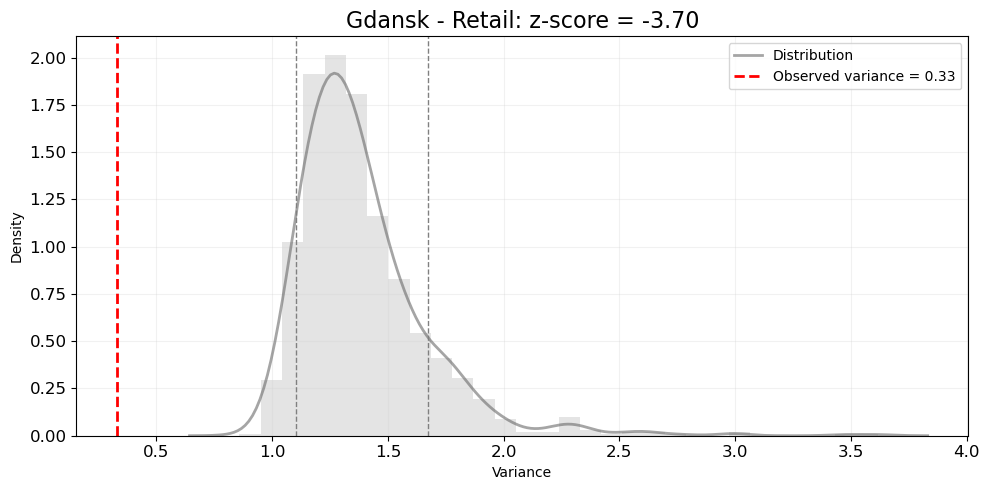

<Figure size 800x500 with 0 Axes>

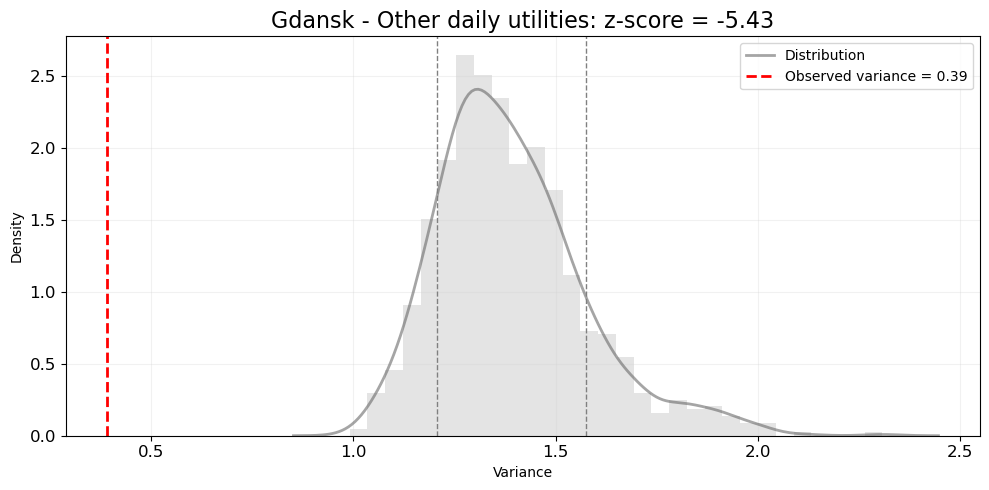

<Figure size 800x500 with 0 Axes>

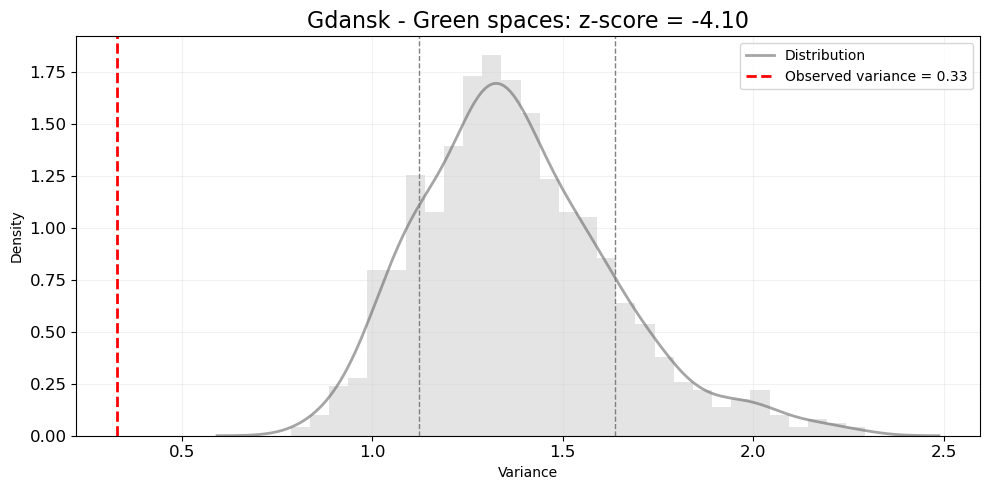

<Figure size 800x500 with 0 Axes>

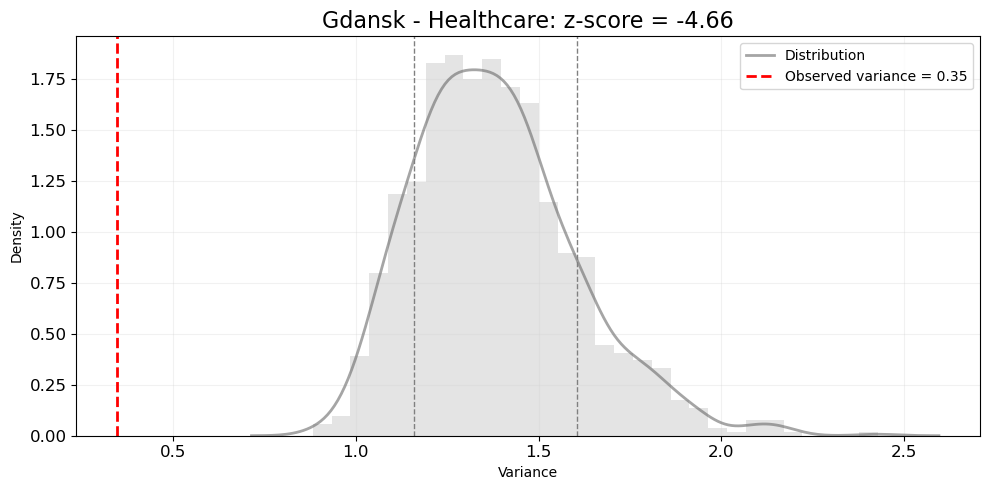

<Figure size 800x500 with 0 Axes>

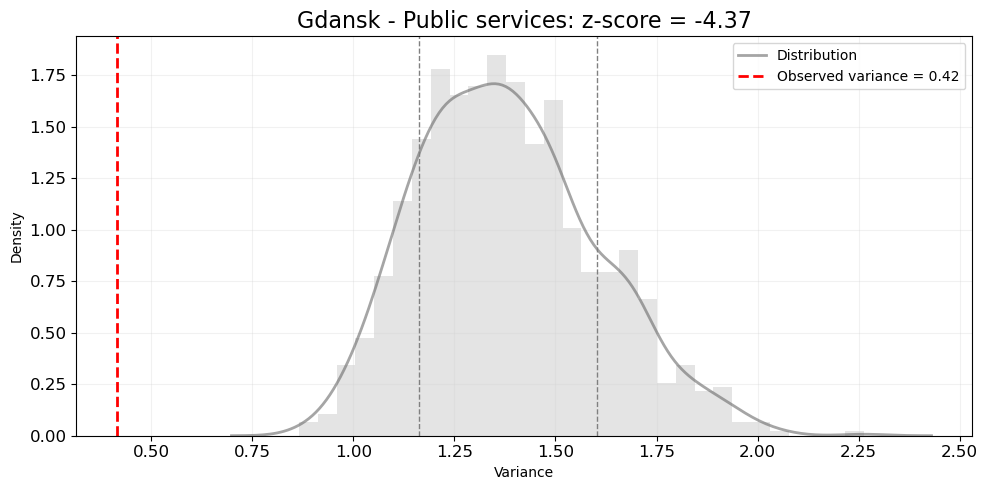

<Figure size 800x500 with 0 Axes>

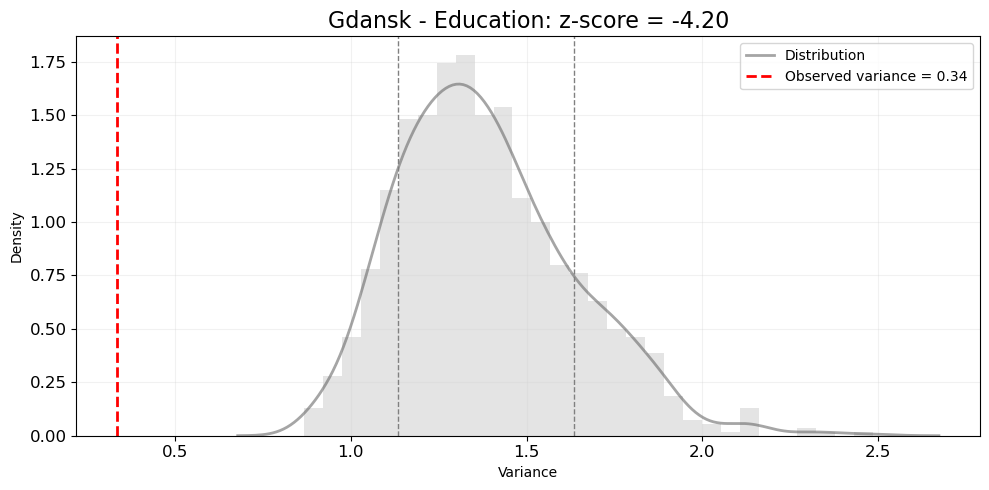

<Figure size 800x500 with 0 Axes>

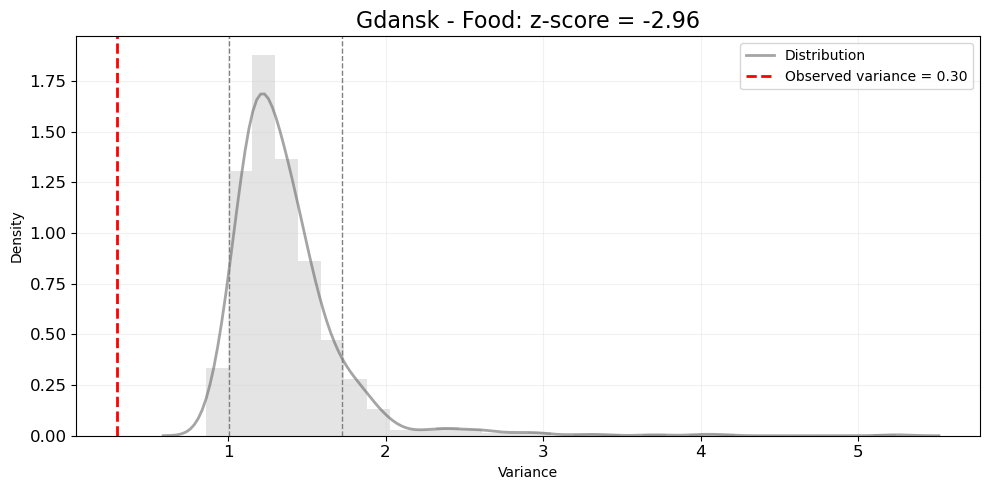

In [46]:
for category in df_z.index:
    plot_variance_distribution_from_results(category, df_z, label_map, CITY_NAME)

In [47]:
df_z

,real_var,mean_rand,std_rand,z_score,rand_vars
infrastructure_transport,0.551850,1.386958,0.183052,-4.562126,"[1.3785534643443114, 1.5215092933449628, 1.360..."
culture_leisure,0.262683,1.359728,0.438194,-2.503561,"[1.3024879735735546, 1.3927319054100675, 1.227..."
retail,0.329183,1.387965,0.285940,-3.702817,"[1.2909261285391014, 1.102035717446431, 1.7122..."
other_daily_utilities,0.392009,1.391368,0.184058,-5.429576,"[1.346344418092486, 1.5074441300544754, 1.3652..."
green_spaces,0.330211,1.379666,0.256255,-4.095356,"[1.520314850387633, 0.8934234937243699, 1.2604..."
healthcare,0.348684,1.382548,0.221913,-4.658869,"[1.3841833427391015, 1.2578382268726178, 1.199..."
public_services,0.415796,1.382775,0.221114,-4.373223,"[2.0256676911081346, 1.5133979557437218, 1.045..."
education,0.336063,1.385150,0.249809,-4.199566,"[1.3552726845149174, 1.0515631887735946, 1.245..."
food,0.298408,1.366081,0.360562,-2.961132,"[1.0423240608826776, 1.1574158665719885, 1.119..."


<Figure size 1000x600 with 0 Axes>

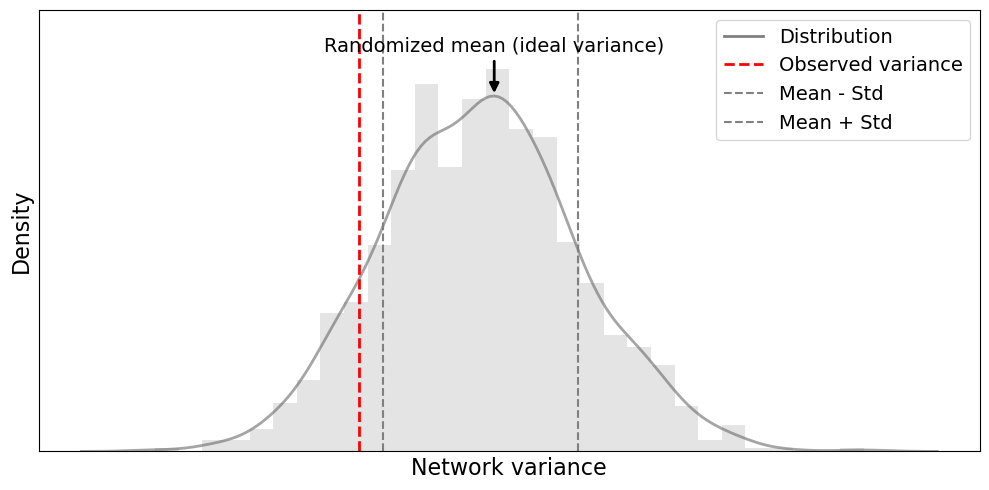

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

plt.rcParams['axes.labelsize'] = 16       # axis labels
plt.rcParams['legend.fontsize'] = 14


# ---------- 1. Generate conceptual (fake) random variance distribution ----------
np.random.seed(42)

rand_vars = np.random.normal(loc=5.0, scale=1.0, size=1000)
real_var = 3.8   # observed variance

mean_rand = np.mean(rand_vars)
std_rand = np.std(rand_vars)

# ---------- 2. First plot KDE to extract peak ----------
plt.figure(figsize=(10, 6))
kdeplot = sns.kdeplot(rand_vars, bw_adjust=1, color="black")
x_vals = kdeplot.get_lines()[0].get_xdata()
y_vals = kdeplot.get_lines()[0].get_ydata()
plt.clf()

# KDE peak
x_peak = x_vals[np.argmax(y_vals)]
y_peak = max(y_vals)

# ---------- 3. Main plot ----------
plt.figure(figsize=(10, 5))

# Histogram (light grey)
sns.histplot(
    rand_vars,
    bins=30,
    stat='density',
    color="lightgray",
    edgecolor=None,
    alpha = 0.6
)

# KDE curve (dark grey)
sns.kdeplot(
    rand_vars,
    bw_adjust=1,
    color="dimgray",
    linewidth=2,
    alpha = 0.6
)


plt.axvline(real_var, color="red", linestyle="--", linewidth=2,
            label="Observed variance")
plt.axvline(mean_rand - std_rand, color="gray", linestyle="--",
            label="Mean - Std")
plt.axvline(mean_rand + std_rand, color="gray", linestyle="--",
            label="Mean + Std")

# ---- Expand y-axis so arrow + label fit inside ----
ylim = plt.ylim()
plt.ylim(ylim[0], ylim[1] * 1.1)

plt.annotate(
    "Randomized mean (ideal variance)",
    xy=(x_peak, y_peak),
    xytext=(x_peak, y_peak + 0.05),
    ha='center',
    fontsize=14,  
    arrowprops=dict(arrowstyle='-|>', color="black", lw=2)
)

plt.xlabel("Network variance")
plt.ylabel("Density")
plt.grid(True, which='both', color="lightgray", alpha=0.3)
plt.xticks([])
plt.yticks([])

# -------- Add KDE to legend --------
kde_handle = Line2D([], [], color="gray", linewidth=2, label="Distribution")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=[kde_handle] + handles)

plt.tight_layout()

# ---- Save as PDF ----
plt.savefig("variance_plot.pdf", format="pdf", bbox_inches="tight")


plt.show()


Livability score

In [49]:
# Check the list of z-scores and rhe rows of GE matrix are consistens
print("Categories in GE:", df_ge.index.tolist())
print("Categories in z:", df_z.index.tolist())

Categories in GE: ['infrastructure_transport', 'culture_leisure', 'retail', 'other_daily_utilities', 'green_spaces', 'healthcare', 'public_services', 'education', 'food']
Categories in z: ['infrastructure_transport', 'culture_leisure', 'retail', 'other_daily_utilities', 'green_spaces', 'healthcare', 'public_services', 'education', 'food']


In [50]:
# Align df_z to the same order as df_ge. So they correspond exactly
df_z_aligned = df_z.reindex(df_ge.index)

# Save z-scores
z_scores = df_z_aligned["z_score"].values

In [51]:
# Check if it worked, if the z-scores match
for cat, z in zip(df_ge.index, z_scores):
    print(f"{cat}: {z}")

infrastructure_transport: -4.562125931564781
culture_leisure: -2.503561010758759
retail: -3.702817368980287
other_daily_utilities: -5.429575987282595
green_spaces: -4.095356298455936
healthcare: -4.658869132343549
public_services: -4.373222558891906
education: -4.19956587650311
food: -2.961132057482848


In [52]:
df_ge.head()

,infrastructure_transport,culture_leisure,retail,other_daily_utilities,green_spaces,healthcare,public_services,education,food
infrastructure_transport,0.000000,0.100852,0.083640,0.054924,0.082467,0.081749,0.087801,0.066587,0.124505
culture_leisure,0.100852,0.000000,0.095025,0.094875,0.075125,0.105159,0.067490,0.093163,0.079890
retail,0.083640,0.095025,0.000000,0.069788,0.069045,0.048408,0.073625,0.058002,0.098524
other_daily_utilities,0.054924,0.094875,0.069788,0.000000,0.072517,0.073509,0.075017,0.050690,0.118591
green_spaces,0.082467,0.075125,0.069045,0.072517,0.000000,0.072126,0.052489,0.057790,0.088364


In [54]:
# Livabiity score for the city
livability = compute_livability_from_matrix(df_ge, z_scores)
print("Livability score:", livability)

Livability score: 0.043354532088935874


Normalization 1 - use the average instead of the sum

In [56]:
# Livabiity score for the city
livability_normalized1 = compute_livability_normalized_1(df_ge, z_scores)
print("Livability score (with using average instead of sum):", livability_normalized1)

Livability score (with using average instead of sum): 3.121526310403383


Normalization 2 - add weights to the edges in graph

In [57]:
list(G_largest.edges(data=True))[:20]

[(0, 1, {}),
 (0, 2, {}),
 (0, 3, {}),
 (1, 758, {}),
 (1, 723, {}),
 (1, 749, {}),
 (1, 700, {}),
 (1, 715, {}),
 (1, 665, {}),
 (1, 707, {}),
 (1, 653, {}),
 (1, 782, {}),
 (1, 837, {}),
 (1, 770, {}),
 (1, 881, {}),
 (1, 849, {}),
 (1, 245, {}),
 (1, 107, {}),
 (1, 19, {}),
 (1, 2, {})]

In [59]:
# Make a weighted copy of the graph
G_weighted = G_largest.copy()

# Add degree-based weights
G_weighted = add_inv_degree_weights(G_weighted)

# Recompute Q and GE matrix using the weighted graph
Q_weighted = compute_and_store_Q(G_weighted, CITY_NAME)

# Prepare category dictionaries
category_dicts_largest_weighted = prepare_category_dicts(category_counts, G_weighted)

# Compute GE matrix
df_ge_weighted = compute_generalized_euclidean_matrix(
    G_weighted, category_dicts_largest_weighted, ge=ge, Q_func=lambda G: Q_weighted
)

resistance_matrix_weighted = precompute_resistance(G_weighted)

# Compute variance for each category (using precomputed resistance matrix)
variance_categories_weighted = compute_variance(category_dicts_largest_weighted, G_weighted, resistance_matrix_weighted)

# Compute z-scores
df_z_weighted = compute_z_scores(category_dicts_largest_weighted, G_weighted, resistance_matrix_weighted, n_iter=1000)

# Align df_z to the same order as df_ge. So they correspond exactly
df_z_aligned_weighted = df_z_weighted.reindex(df_ge_weighted.index)

# Save z-scores
z_scores_weighted = df_z_aligned_weighted["z_score"].values

                           variance
infrastructure_transport  27.843481
culture_leisure           15.808948
retail                    19.261531
other_daily_utilities     22.237875
green_spaces              19.738332
healthcare                19.250775
public_services           23.018231
education                 19.192939
food                      16.679083


In [60]:
print(df_ge.compare(df_ge_weighted))

                         infrastructure_transport           culture_leisure  \
                                             self     other            self   
infrastructure_transport                      NaN       NaN        0.100852   
culture_leisure                          0.100852  0.298789             NaN   
retail                                   0.083640  0.245412        0.095025   
other_daily_utilities                    0.054924  0.153224        0.094875   
green_spaces                             0.082467  0.241711        0.075125   
healthcare                               0.081749  0.240628        0.105159   
public_services                          0.087801  0.255306        0.067490   
education                                0.066587  0.191608        0.093163   
food                                     0.124505  0.366564        0.079890   

                                      retail           other_daily_utilities  \
                             other      self     o

In [61]:
# Compute livability score
livability_normalized2 = compute_livability_from_matrix(df_ge_weighted, z_scores_weighted)

print("Livability with weighted edges:", livability_normalized2)

Livability with weighted edges: 0.01525552792460476


Normalization 3 - normalizing generalized euclidean

In [62]:
# Normalize GE matrix so that all values sum to 1 - global 
def normalize_ge_sum_to_one(df_ge):
    GE = df_ge.values.astype(float).copy()
    np.fill_diagonal(GE, 0.0)             # ensure diagonal = 0
    s = GE.sum()                          # total sum of all distances
    if s > 0:
        GE = GE / s                       # divide all by total sum
    return pd.DataFrame(GE, index=df_ge.index, columns=df_ge.columns)

df_ge_sum1 = normalize_ge_sum_to_one(df_ge)

In [63]:
print("Sum of GE before:", df_ge.values.sum())
print("Sum of GE after :", df_ge_sum1.values.sum())

Sum of GE before: 5.77390483071278
Sum of GE after : 1.0


In [64]:
# Compute livability again using normalized GE
livability_normalized3 = compute_livability_from_matrix(df_ge_sum1, z_scores)
print("Livability score (with normalized GE):", livability_normalized3)

Livability score (with normalized GE): 0.25032494226159907


In [65]:
# Row normalization; per category. Every row sum up to 1
def normalize_ge_rowwise(df_ge):
    GE = df_ge.values.astype(float).copy()
    np.fill_diagonal(GE, 0.0)
    row_sums = GE.sum(axis=1, keepdims=True)
    # avoid division by zero
    GE = np.divide(GE, row_sums, where=row_sums!=0)
    return pd.DataFrame(GE, index=df_ge.index, columns=df_ge.columns)

df_ge_row = normalize_ge_rowwise(df_ge)

In [66]:
livability_rowwise = compute_livability_from_matrix(df_ge_row, z_scores)
print("Livability score (row-normalized GE):", livability_rowwise)

Livability score (row-normalized GE): 0.027407602910432087


Normalization 4 - Logarithm of ge

In [67]:
# Copy GE matrix
GE = df_ge.values.astype(float)

# Replace zeros to avoid log(0)
GE[GE <= 0] = 1e-9

# Apply logarithm
GE_log = np.log(GE)

# Create DataFrame again
df_ge_log = pd.DataFrame(GE_log, index=df_ge.index, columns=df_ge.columns)

In [68]:
# Compute livability again
livability_log = compute_livability_from_matrix(df_ge_log, z_scores)
print("Livability (log-transformed GE):", livability_log)

Livability (log-transformed GE): -0.0006640455104393868


Testing the logic of the formula

In [69]:
# Test a livability computation function across multiple edge cases
# livability_func must take (z, GE) as inputs and return a numeric score.

def test_livability_method(livability_func):

    # Base example
    z = np.array([-11, -7, -5])
    GE = np.array([[0,1,2],[1,0,3],[2,3,0]])
    base = livability_func(z, GE)

    # Larger city (distances x10)
    large = livability_func(z, GE * 10)

    # Smaller city (distances /10)
    small = livability_func(z, GE * 0.1)

    # More POIs within the same category
    GE_more_pois = GE * 0.9  # smaller = denser categories
    many = livability_func(z, GE_more_pois)

    # All z = 0
    z_balanced = np.zeros_like(z)
    balanced = livability_func(z_balanced, GE)

    # No POIs
    empty = livability_func([], np.zeros((0,0)))

    print("Base city:", base)
    print("Larger city (distances bigger):", large)
    print("Smaller city (distances smaller):", small)
    print("More POIs:", many)
    print("All z=0 (perfect balance):", balanced)
    print("No POIs:", empty)


In [70]:
def livability_unnormalized(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    return 1 / ((z[:, None] * GE).sum() + 1e-9)


print("Unnormalized:")
test_livability_method(livability_unnormalized)

Unnormalized:
Base city: 0.011627906976608978
Larger city (distances bigger): 0.0011627906976730666
Smaller city (distances smaller): 0.11627906975392102
More POIs: 0.012919896640659949
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [71]:
def livability_average(z, GE):
    if len(z) < 2:
        return np.nan
    z = np.abs(z)
    n = len(z)
    total = (z[:, None] * GE).sum() / (n * (n - 1))
    return 1 / (total + 1e-9)


print("Normalization 1:")
test_livability_method(livability_average)

Normalization 1:
Base city: 0.06976744185559762
Larger city (distances bigger): 0.006976744185997837
Smaller city (distances smaller): 0.6976744181179014
More POIs: 0.07751937983895198
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [72]:
# The whole ge matrix sum to one
def livability_sum1(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    GE = GE.astype(float).copy()
    np.fill_diagonal(GE, 0)
    s = GE.sum()
    if s > 0:
        GE = GE / s
    return 1 / ((z[:, None] * GE).sum() + 1e-9)

print("Normalization 3:")
test_livability_method(livability_sum1)

Normalization 3:
Base city: 0.13953488370146025
Larger city (distances bigger): 0.13953488370146025
Smaller city (distances smaller): 0.13953488370146025
More POIs: 0.13953488370146025
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [73]:
# Row normalization: each category's distances sum to 1
def livability_row_normalized(z, GE):
    if len(z) == 0:
        return np.nan

    z = np.abs(z)
    GE = GE.astype(float).copy()

    row_sums = GE.sum(axis=1, keepdims=True)
    GE = np.divide(GE, row_sums, where=row_sums != 0)
    np.fill_diagonal(GE, 0.0)

    total = (z[:, None] * GE).sum()
    return 1 / (total + 1e-9)

print("Normalization 3:")
test_livability_method(livability_row_normalized)

Normalization 3:
Base city: 0.04347826086767486
Larger city (distances bigger): 0.04347826086767486
Smaller city (distances smaller): 0.04347826086767486
More POIs: 0.04347826086767486
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [74]:
def livability_log(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    GE = GE.astype(float).copy()
    GE[GE <= 0] = 1e-9
    GE = np.log(GE)
    return 1 / ((z[:, None] * GE).sum() + 1e-9)


print("Normalization 4:")
test_livability_method(livability_log)

Normalization 4:
Base city: -0.002210621803060352
Larger city (distances bigger): -0.0028864819035638316
Smaller city (distances smaller): -0.0017912148308253184
More POIs: -0.002187188346635496
All z=0 (perfect balance): 999999999.9999999
No POIs: nan
